In [1]:
import sys
sys.path.insert(0, '../gofher')

import os
import matplotlib.image as mpimg

from gofher import run_gofher
from visualize import visualize
from file_helper import write_csv,check_if_folder_exists_and_create
from spin_parity import read_spin_parity_galaxies_label_from_csv, standardize_galaxy_name

In [2]:
survery_to_use = "panstarrs"

BANDS_IN_ORDER = ['g','r','i','z','y'] #Important: Must stay in order of BLUEST to REDDEST Waveband (Editting this will cause gofher to no longer correctly evaluate redder side of galaxy)
REF_BANDS_IN_ORDER = ['i','z','y','r','g'] #The prefernce each waveband being choosen as refernce band from highest priority to lowest priority

In [3]:
figure_to_run_on = "figure11"

In [4]:
generate_verbose_csv = False
generate_ebm_csv = False
generate_visualization = True
save_visualization = False

In [5]:
#Important: Make sure you update these values:
path_to_catalog_data = "..\\..\\..\\spin-parity-catalog-data"
path_to_output = "..\\..\\..\\gofher-data\\panstarrs\\source_extraction"

In [6]:
def get_fits_path(name,band):
    """the file path of where existing fits files can be found"""
    return os.path.join(path_to_catalog_data,survery_to_use,figure_to_run_on,name,"{}_{}.fits".format(name,band))

def get_color_image_path(name):
    return os.path.join(path_to_catalog_data,survery_to_use,figure_to_run_on,name,"{}_color.jfif".format(name))

def get_path_to_catalog_csv():
    return os.path.join(path_to_catalog_data,"catalog","{}.csv".format(figure_to_run_on))

In [7]:
def get_paper_dark_side_labels():
    return read_spin_parity_galaxies_label_from_csv(get_path_to_catalog_csv())

def get_galaxies():
    return os.listdir(os.path.join(path_to_catalog_data,survery_to_use,figure_to_run_on))

In [8]:
def run_gofher_on_catalog():
    paper_labels = get_paper_dark_side_labels()

    verbose_header = []
    verbose_rows = []

    ebm_header = []
    ebm_rows = []

    i = 1


    for name in get_galaxies():

        if standardize_galaxy_name(name) not in paper_labels:
            print("skippimg",name)
            continue

        print(name, i,"of",len(get_galaxies()))

        try:
            paper_label = paper_labels[standardize_galaxy_name(name)]
            gal = run_gofher(name,get_fits_path,BANDS_IN_ORDER,REF_BANDS_IN_ORDER, paper_label)

            if generate_verbose_csv:
                (header,row) = gal.get_verbose_csv_header_and_row(BANDS_IN_ORDER,paper_label)
                if len(verbose_header) == 0: verbose_header = header
                verbose_rows.append(row)

            if generate_ebm_csv:
                (header,row) = gal.get_ebm_csv_header_and_row(BANDS_IN_ORDER, paper_label)
                if len(ebm_header) == 0: ebm_header = header
                ebm_rows.append(row)

            if generate_visualization:
                save_path = ''
                
                if save_visualization:
                    sub_folder = os.path.join(path_to_output,figure_to_run_on)
                    check_if_folder_exists_and_create(sub_folder)
                    save_path = os.path.join(sub_folder,"{}.png".format(name))

                color_image = color = mpimg.imread(get_color_image_path(name))
                visualize(gal,color_image,BANDS_IN_ORDER,paper_label,save_path=save_path)
        except Exception as e:
            print(e)
        i += 1

    if generate_verbose_csv:
        verbose_csv_path = os.path.join(path_to_output,"{}_verbose.csv".format(figure_to_run_on))
        write_csv(verbose_csv_path,verbose_header,verbose_rows)

    if generate_ebm_csv:
        ebm_csv_path = os.path.join(path_to_output,"{}_ebm.csv".format(figure_to_run_on))
        write_csv(ebm_csv_path,ebm_header,ebm_rows)

IC2247 1 of 25


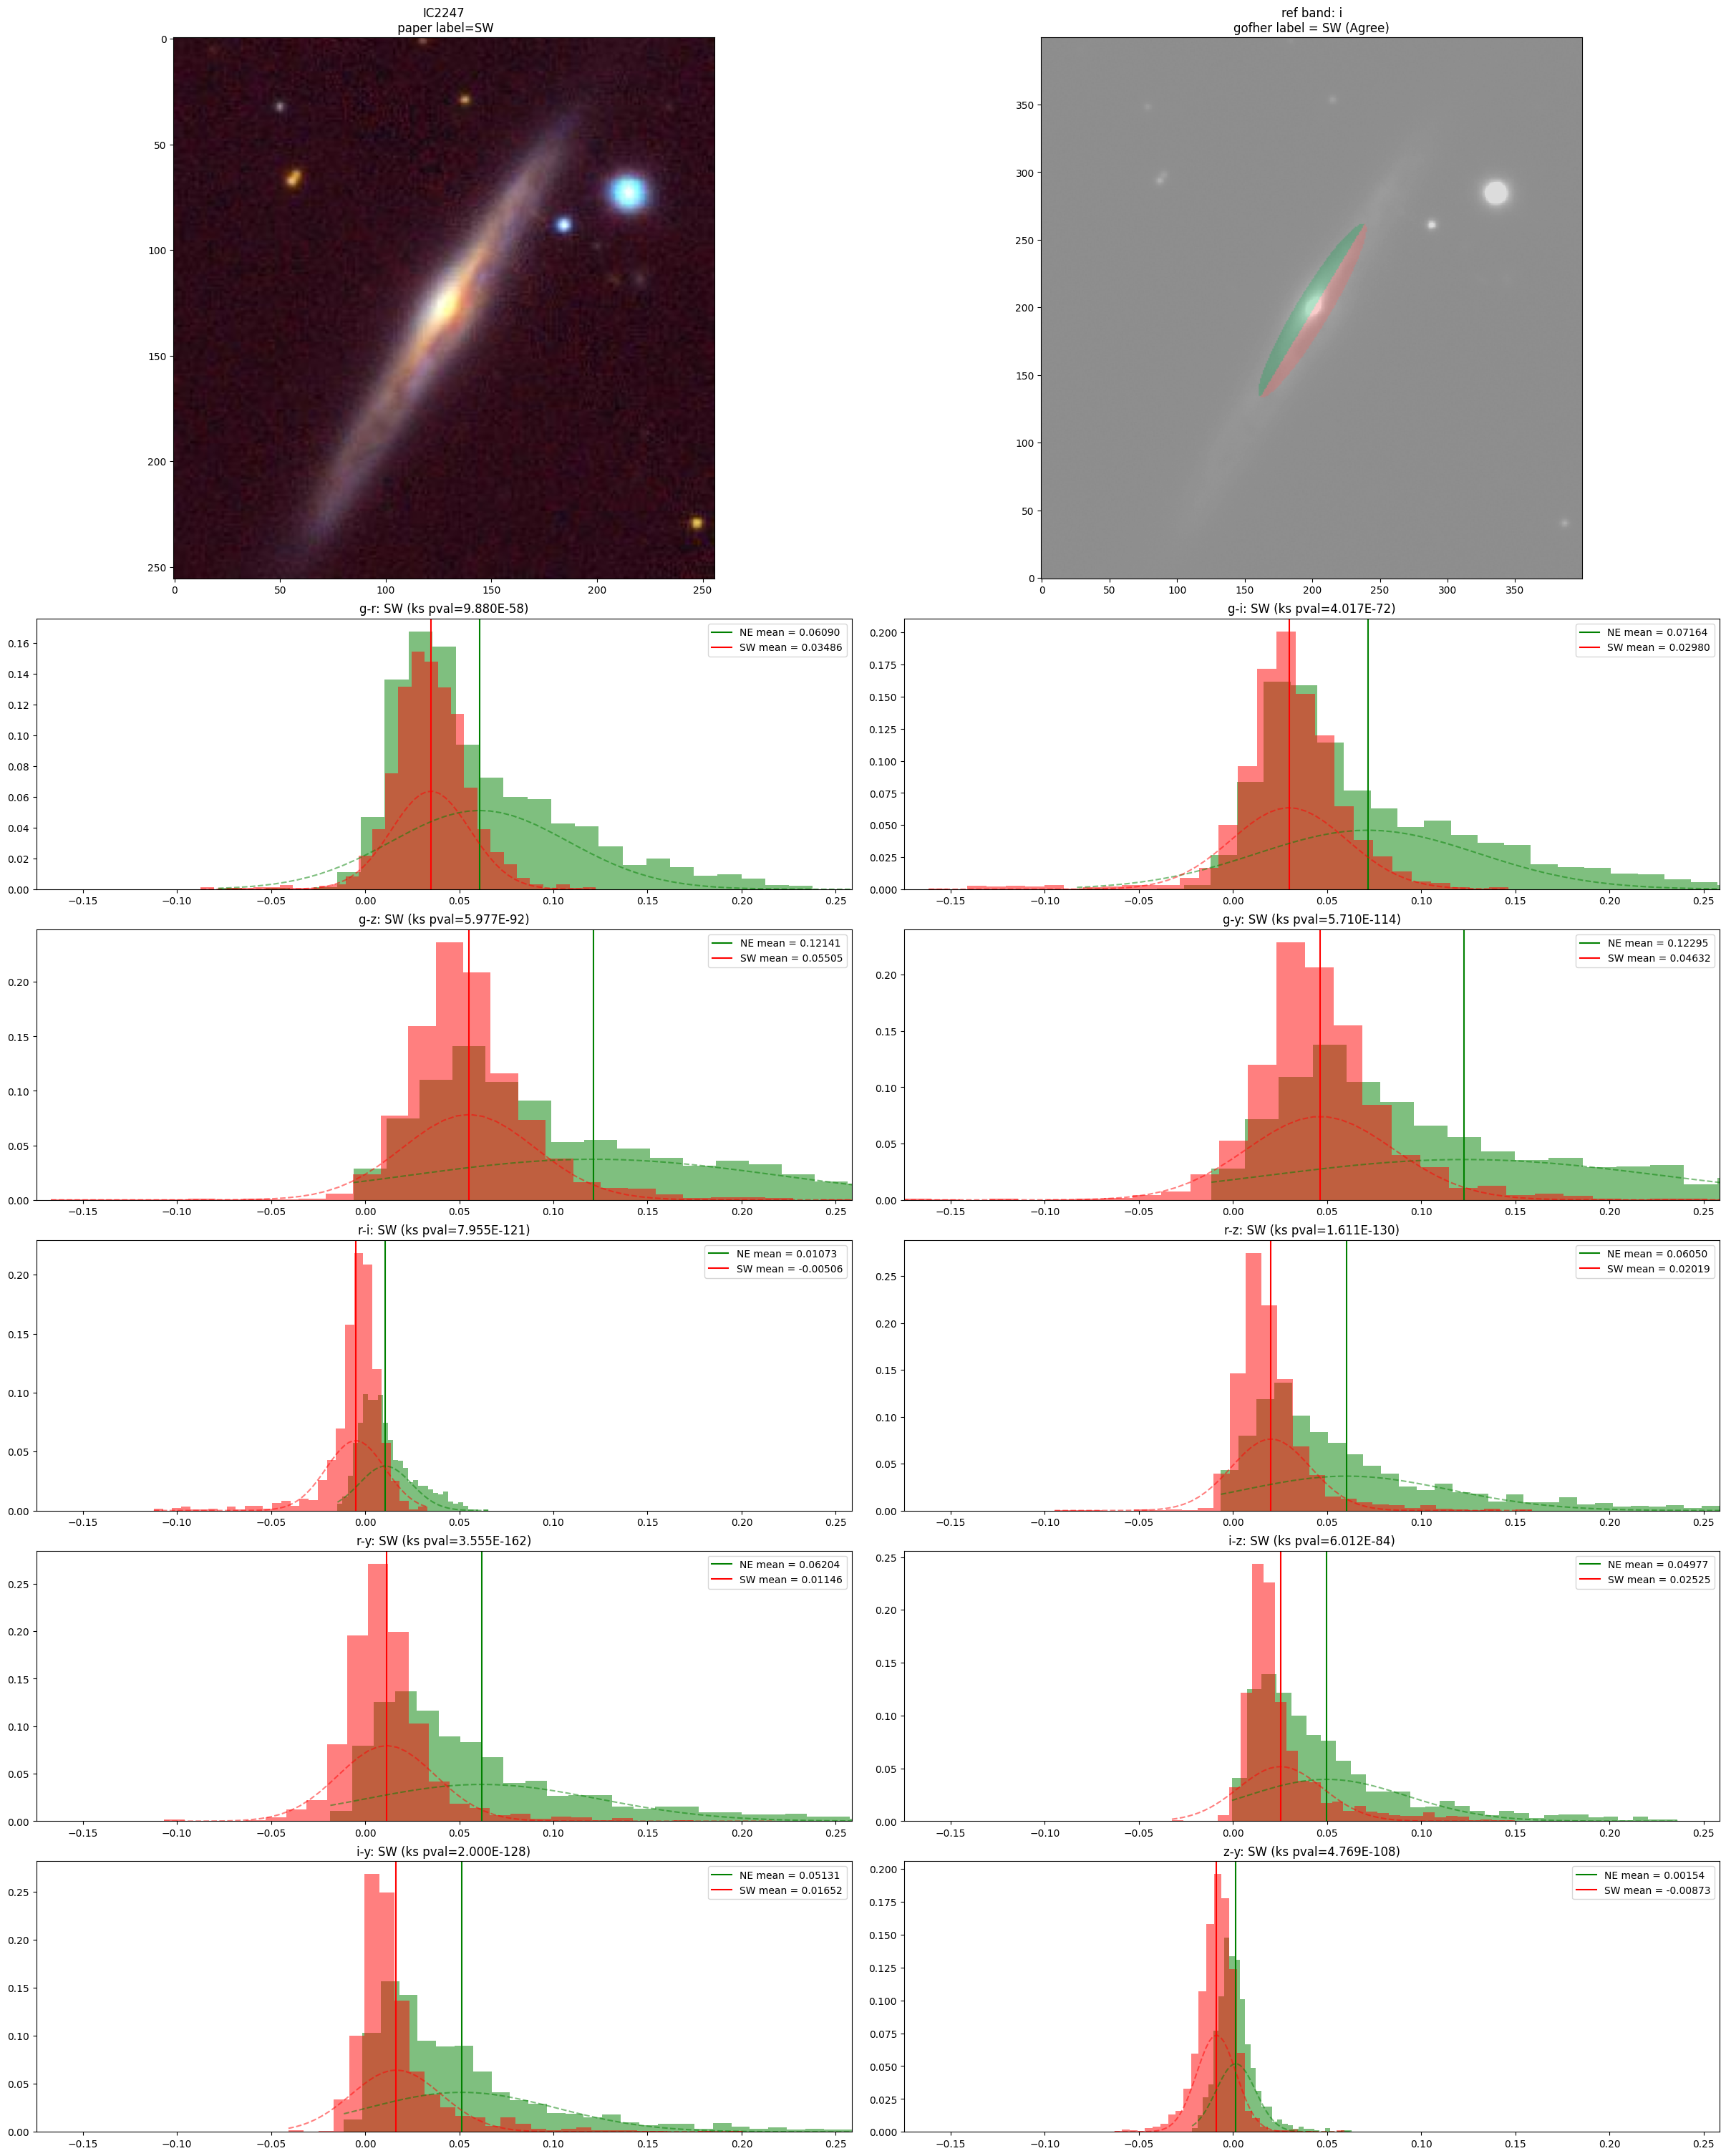

In [9]:
if not os.path.exists(path_to_catalog_data):
    raise ValueError("The path to the catalog is not found {} - make sure you update path_to_catalog_data".format(path_to_catalog_data))

if not os.path.exists(path_to_output):
    raise ValueError("The path output is not found {} - make sure you update ppath_to_output".format(path_to_catalog_data))


run_gofher_on_catalog()